# Backtrader 완전 가이드 - 사용법 실습

## 학습 목표
- Backtrader의 핵심 개념 이해하기
- Strategy 클래스 작성 방법 익히기
- 지표(Indicator) 사용법 배우기
- 분석기(Analyzer) 활용하기
- 실전 팁과 주의사항

## Backtrader란?
파이썬으로 작성된 백테스팅 프레임워크로, 매매 전략을 시뮬레이션할 수 있습니다.

In [1]:
import backtrader as bt
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False  # 마이너스 깨짐 방지

print("라이브러리 임포트 완료!")
print(f"Backtrader 버전: {bt.__version__}")

라이브러리 임포트 완료!
Backtrader 버전: 1.9.78.123


---
## Part 1: 기본 구조 이해하기

### 1.1 Backtrader의 3대 요소

```
┌─────────────────┐
│   Cerebro       │  엔진 (실행 관리)
│    (엔진)        │
└────────┬────────┘
         │
    ┌────┴────┬────────┬──────────┐
    │         │        │          │
┌───▼───┐ ┌──▼──┐ ┌───▼────┐ ┌───▼────┐
│ Data  │ │Strat│ │Analyzer│ │ Broker │
│(데이터)│ │(전략)│ │(분석기) │ │(브로커) │
└───────┘ └─────┘ └────────┘ └────────┘
```

### 1.2 데이터 준비하기

In [2]:
# 삼성전자 데이터 다운로드
ticker = '005930.KS'
data = yf.download(ticker, start='2023-01-01', end='2024-12-31', multi_level_index=False)

print(f"데이터 준비 완료")
print(f"   종목: 삼성전자")
print(f"   기간: {data.index[0].date()} ~ {data.index[-1].date()}")
print(f"   행 수: {len(data):,}개")

# 데이터 구조 확인
print("\n데이터 샘플:")
print(data.head(3))

C:\Users\panis\AppData\Local\Temp\ipykernel_1644\927074654.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start='2023-01-01', end='2024-12-31', multi_level_index=False)
[*********************100%***********************]  1 of 1 completed

데이터 준비 완료
   종목: 삼성전자
   기간: 2023-01-02 ~ 2024-12-30
   행 수: 489개

데이터 샘플:
                   Close          High           Low          Open    Volume
Date                                                                        
2023-01-02  52343.421875  52909.296706  52060.484459  52343.421875  10031448
2023-01-03  52249.101562  52814.976309  51400.289443  52249.101562  13547030
2023-01-04  54512.605469  54701.230401  52437.731212  52532.043678  20188071


In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 489 entries, 2023-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   489 non-null    float64
 1   High    489 non-null    float64
 2   Low     489 non-null    float64
 3   Open    489 non-null    float64
 4   Volume  489 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 22.9 KB


### 1.3 Backtrader 데이터 피드 만들기

- Pandas DataFrame을 Backtrader가 읽을 수 있는 형식으로 변환합니다.
  - backtrader는 OHLCV(+openinterest+datetime)에 해당하는 컬럼만 라인으로 매핑
  - 브로커/체결/포트폴리오 계산은 OHLCV 만 사용

In [3]:
# 방법 1: PandasData 사용 (권장)
data_bt = bt.feeds.PandasData(dataname=data)

print("Backtrader 데이터 피드 생성 완료")

Backtrader 데이터 피드 생성 완료


- datas
  - 전체 데이터 피드 리스트

  - adddata 호출순서대로 datas 리스트에 datas[0], datas[1], datas[2], ...
    - datas[0] 의 alias == data0
      - data0 의 alias == data
    - datas[1] 의 alias == data1
    - datas[2] 의 alias == data2
    - ...

- data 활용
  - data0
    - close1 = self.data.close[0]   # OK data0 에 대한 alias => data
    - close2 = self.data0.close[0]  # OK
    - close3 = self.datas[0].close[0]  # OK
  - data1
    - close4 = self.data1.close[0]  # OK
    - close5 = self.datas[1].close[0]  # OK

```
Backtrader 내부 동작 순서를 단순화하면 대략 이렇게 됩니다:

데이터 피드를 읽어서 내부 버퍼에 다 채움

Strategy.__init__() 호출

이때 커서가 데이터의 맨 끝(마지막 바)에 가 있습니다.

그래서 self.data.datetime[0] → 전체 중 마지막 날짜

그런 다음 내부에서 커서를 다시 앞으로 되감고(rewind),

처음 바부터 차례대로 next()를 호출하면서 진행

마지막 바까지 다 돌면 stop() 호출

이때도 커서는 마지막 바에 서 있습니다.
```

- Cerebro는 내부에서 각 데이터 피드의 datetime을 보고 동기화합니다.
  - 같은 종목이라도 타임프레임(일봉, 월봉)이 다르면 상관없음
  - 다른 종목이고 타임프레임이 달라도 상관없음
  
- data 마다 시점이 다르면 가장 이른 시점을 기준으로 next() 가 호출되기 시작함
  - next() 호출 시점이 있는 data 들만 처리
  
```python
data_a = bt.feeds.PandasData(dataname=df_a)   # A 종목
data_b = bt.feeds.PandasData(dataname=df_b)   # B 종목


cerebro.adddata(data_a)   # → Strategy에서 self.data0
cerebro.adddata(data_b)   # → Strategy에서 self.data1
```

In [4]:
data_bt

## 1.4 사용자 칼럼 추가

- 사용자 칼럼 추가 가능
  - 추가 라인은 전략 로직에서만 읽는 용도

```python
import backtrader.feeds as btfeeds

class PandasWithFactors(btfeeds.PandasData):
    # 기존 OHLCV 라인 외에 2개 라인 추가
    lines = ('factor1', 'factor2',)

    # DataFrame 컬럼을 어떤 라인에 매핑할지 지정
    # -1 이면: 같은 이름의 컬럼을 자동으로 찾음 (df['factor1'], df['factor2'])
    params = (
        ('factor1', -1),
        ('factor2', -1),
    )
```

```python
data = PandasWithFactors(dataname=df)
cerebro.adddata(data)

class MyStrategy(bt.Strategy):
    def next(self):
        f1 = self.data.factor1[0]
        f2 = self.data.factor2[0]

        if self.data.close[0] > self.data.open[0] and f1 > 0 and f2 < 10:
            self.buy()
```

---
## Part 2: Strategy 클래스 작성하기

### 2.1 Strategy의 핵심 메서드

| 메서드 | 실행 시점 | 용도 |
|--------|-----------|------|
| `__init__()` | 전략 시작 전 (1회) | 지표 계산, 초기화 |
| `next()` | 매일 (or 매 봉) | 매매 로직 실행 |
| `notify_order()` | 주문 상태 변경 시 | 주문 체결 확인 |
| `notify_trade()` | 거래 종료 시 | 손익 확인 |
| `stop()` | 백테스트 종료 후 (1회) | 최종 결과 출력 |

- next()

  - 그날 bar 기준으로 기존에 대기 중이던 주문들을 먼저 브로커가 처리한 뒤

  - 그 결과가 반영된 포지션/계좌 상태를 가지고 호출되는 함수입니다.

  - next() 안에서 낸 주문은 항상 다음 bar부터 체결될 수 있습니다.

### 2.2 가장 간단한 전략: 조건부 매수

- Strategy Class 구조
  - 메인 엔진 run
  - Strategy instance 호출
    - 초기화
    - 일자별 next() 호출
      - feeds 에 등록된 일수
    - 모든 일자별 실행 후 stop() 호출

- position
  - 브로커가 업데이트한 포지션 정보를 Strategy에서 읽어오는 창구
  - 주문 체결 결과에 따라 자동으로 업데이트
  - self.position == self.getposition(self.data0)

- 주식에서 포지션
  - 실제로 보유하고 있는 매매 상태
  - 주식매수 : 롱 포지션(매수 후 보유상태) > 0
  - 주식매도 : 숏 포지션(공매도 후 보유상태) < 0
  - 매매 진행 중 : 오픈 포지션

```python
if not self.position:
        # 아직 아무 포지션 없음 → 진입 조건 체크
        if 매수조건:
            self.buy()
    else:
        # 이미 포지션 있음 → 청산 조건 체크
        if 청산조건:
            self.close()
            
if self.position.size > 0:
    # 롱 포지션 중
    # self.position.price 를 활용해서 수익률 계산 후 익절/손절 판단
    if (self.data.close[0] - self.position.price) / self.position.price > 0.1:
        self.close()
```

In [5]:
class SimpleBuyStrategy(bt.Strategy):
    """
    간단한 매수 전략
    - 첫 10일은 관망
    - 11일째에 매수
    - 끝까지 보유
    """
    
    def __init__(self):
        """초기화: 한 번만 실행"""
        self.day_count = 0
        print("전략 초기화 완료")
    
    def next(self):
        """매일 실행되는 메인 로직"""
        self.day_count += 1
        
        # 11일째에 매수
        if self.day_count == 11 and not self.position:
            # 전체 금액으로 매수
            self.buy()
            print(f"{self.data.datetime.date(0)}: 매수 실행")
    
    def stop(self):
        """백테스트 종료 시 후처리 hook 개념"""
        print(f"전략 종료 (총 {self.day_count}일 실행)")

### 2.3 실행해보기

In [6]:
# Cerebro 생성
cerebro = bt.Cerebro()

# 초기 자금
cerebro.broker.setcash(10_000_000)

# 데이터 추가
cerebro.adddata(data_bt)

# 전략 추가
cerebro.addstrategy(SimpleBuyStrategy)

print(f"\n{'='*50}")
print(f"백테스트 시작")
print(f"{'='*50}\n")

# 실행
start_value = cerebro.broker.getvalue()
cerebro.run()
end_value = cerebro.broker.getvalue()

print(f"\n{'='*50}")
print(f"시작 자금: {start_value:,.0f}원")
print(f"최종 자금: {end_value:,.0f}원")
print(f"수익률: {(end_value-start_value)/start_value*100:.2f}%")
print(f"{'='*50}\n")


백테스트 시작

전략 초기화 완료
2023-01-16: 매수 실행
전략 종료 (총 489일 실행)

시작 자금: 10,000,000원
최종 자금: 9,994,611원
수익률: -0.05%



---
## Part 3: 주문(Order) 관리하기

### 3.1 다양한 주문 방법

- self.buy()
- self.sell()
- self.close()

In [7]:
class OrderMethodsDemo(bt.Strategy):
    """
    주문 방법 데모
    """
    
    def __init__(self):
        self.day_count = 0
    
    def next(self):
        self.day_count += 1
        
        if self.day_count == 10:
            # 방법 1: 단순 매수 (가능한 만큼)
            self.buy()
            print(self.data.datetime.date(0))
            print("방법 1: buy() - 전체 금액으로 매수")
        
        elif self.day_count == 20:
            # 방법 2: 수량 지정 매수
            self.buy(size=10)
            print(self.data.datetime.date(0))
            print("방법 2: buy(size=10) - 10주 매수")
        
        elif self.day_count == 30:
            # 방법 3: 금액 지정 매수
            cash = self.broker.getcash()
            price = self.data.close[0]
            size = int((cash * 0.5) / price)  # 현금의 50%
            self.buy(size=size)
            print(self.data.datetime.date(0))
            print(f"방법 3: 현금의 50%로 매수 ({size}주)")
        
        elif self.day_count == 40:
            # 방법 4: 전량 매도
            self.close()
            print(self.data.datetime.date(0))
            print("방법 4: close() - 전량 매도")

In [8]:
# 실행
cerebro_o = bt.Cerebro()
cerebro_o.broker.setcash(10_000_000)
cerebro_o.adddata(data_bt)
cerebro_o.addstrategy(OrderMethodsDemo)

print(f"\n{'='*60}")
print("오더방법 데모 실행")
print(f"{'='*60}")
cerebro_o.run()


오더방법 데모 실행
2023-01-13
방법 1: buy() - 전체 금액으로 매수
2023-01-31
방법 2: buy(size=10) - 10주 매수
2023-02-14
방법 3: 현금의 50%로 매수 (78주)
2023-02-28
방법 4: close() - 전량 매도


### 3.2 주문 상태 확인하기

- 이번 bar에서 낸 주문은, 보통 <font color=yellow>다음 bar 기준 가격</font>으로 체결된다
  - 다음 next() 에 들어오는 data 기준
  - bar : open, high, low, close, volume
    - 초단위 가격이 모두 있는게 아니라, <font color=red>5개 값만 기준</font>으로 함. 즉, 범위가 아닌 경계선 값 기준

- exectype=Market
  - 다음 bar 의 open 가격

- exectype=Limit
  - buy : (open <=limit) or (low <=limit)
  - sell : (open >=limit) or (high >=limit)
  - 시간의 흐름으로 먼저 조건을 만족하면 체결되는것으로 가정

- exectype=stop
  - Stop = “트리거(조건) + 그 순간 시장가(에 준하는 가격)로 실행”
  - 시간의 흐름으로 먼저 조건을 만족하면 체결되는것으로 가정

  - Buy Stop(short position 손절) : 공매도로 빌린 주식을 사서 청산
    - open >= stop or (high >=stop)

  - Sell Stop(long position 손절) : 기준가격 밑으로 떨어지면 청산
    - open <= stop or (low <=stop)

- [.buy(), .sell()] 리턴값 : 주문을 추적하기 위한 핸들(번호표) : 주문 완료, 주문실패 등의 정보를 확인
  - strategy 인스턴스.buy() => self.broker.buy() 호출 => broker 가 order 객체를 만들고 등록한 주문 객체

  - order.ref : 주문 고유 번호

  - order.data : 어느 data feed 에 대한 주문인지

  - order.size, order.price
  
  - order.executed : 체결 결과
    - order.executed.price # 체결 평균 가격
    - order.executed.size # 누적 체결 수량

  - order.status
    - order.Submitted   # 브로커에 전송됨, 응답 대기
    - order.Accepted    # 브로커가 수락
    - order.Partial     # 부분 체결
    - order.Completed   # 전량 체결
    - order.Canceled    # 사용자가 취소
    - order.Expired     # 유효기간 만료
    - order.Margin      # 증거금/현금 부족
    - order.Rejected    # 브로커가 거절

  - order 객체 상태가 변경되면 notify_order(self, order) 를 호출하며 상태를 알려준다

### 3.3 포지션 상태 확인하기

- position
  - 브로커가 업데이트한 포지션 정보를 Strategy에서 읽어오는 창구
  - 주문 체결 결과에 따라 자동으로 업데이트
  - self.position == self.getposition(self.data0)

- 주식에서 포지션
  - 실제로 보유하고 있는 매매 상태
  - 주식매수 : 롱 포지션(매수 후 보유상태) > 0
  - 주식매도 : 숏 포지션(공매도 후 보유상태) < 0
  - 매매 진행 중 : 오픈 포지션

- 실제로 보유하고 있는 매매 상태
  - position.size # 현재 포지션 수량
  - position.price # 가중 평균 진입 가격

- self.close() 는 현재 포지션(롱이든 숏이든)을 전부 청산하는 주문을 브로커에 보냅니다

  - 내부적으로는 <font color=orange>포지션 0 만들기 유틸리티</font>

  - 롱 포지션(size > 0)이면 → 자동으로 sell(size=현재 size) 주문

  - 숏 포지션(size < 0)이면 → 자동으로 buy(size=현재 |size|) 주문

```python
def next(self):
    # A = data0, B = data1 이라고 가정

    pos_A = self.getposition(self.data0)
    pos_B = self.getposition(self.data1)

    # A 종목 수익이 5% 넘으면 A만 청산
    if pos_A.size > 0 and (self.data0.close[0] - pos_A.price) / pos_A.price > 0.05:
        self.close(data=self.data0)

    # B 종목 손실이 -3% 넘으면 B만 청산
    if pos_B.size < 0 and (self.data1.close[0] - pos_B.price) / pos_B.price < -0.03:
        self.close(data=self.data1)
```

In [9]:
class OrderStatusDemo(bt.Strategy):
    """
    주문 상태 확인 데모
    """
    
    def __init__(self):
        self.order = None
        self.buy_count = 0
    
    def next(self):
        # 이미 주문이 있으면 대기
        if self.order:
            return
        
        # 포지션이 없고 매수 횟수가 3회 미만이면 매수
        if not self.position and self.buy_count < 3:
            self.order = self.buy()
            self.buy_count += 1
            print(f"\n매수 주문 제출: {self.data.datetime.date(0)}")
    
    def notify_order(self, order):
        """주문 상태 변경 시 호출"""
        date = self.data.datetime.date(0)
        print('주문상태 변경 시점:',date)
        
        # 주문이 제출됨
        if order.status in [order.Submitted]:
            print(f"   주문 제출됨")
            return
        
        # 주문이 접수됨
        if order.status in [order.Accepted]:
            print(f"   주문 접수됨")
            return
        
        # 주문이 체결됨
        if order.status in [order.Completed]:
            if order.isbuy():
                print(f"   매수 체결!")
                print(f"      가격: {order.executed.price:,.0f}원")
                print(f"      수량: {order.executed.size:.0f}주")
                print(f"      수수료: {order.executed.comm:,.0f}원")
            else:
                print(f"   매도 체결!")
                print(f"      가격: {order.executed.price:,.0f}원")
                print(f"      수량: {order.executed.size:.0f}주")
        
        # 주문이 취소/거부됨
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print(f"   주문 실패: {order.getstatusname()}")
        
        # 주문 완료 - 다음 주문 가능
        # 내가 기억해 두었던 그 주문이 마무리되었으면 리셋
        self.order = None

In [10]:
# 실행
cerebro_os = bt.Cerebro()
cerebro_os.broker.setcash(10_000_000)
cerebro_os.adddata(data_bt)
cerebro_os.addstrategy(OrderStatusDemo)

print(f"\n{'='*60}")
print("오더상태 데모 실행")
print(f"{'='*60}")
cerebro_os.run()


오더상태 데모 실행

매수 주문 제출: 2023-01-02
주문상태 변경 시점: 2023-01-03
   주문 제출됨
주문상태 변경 시점: 2023-01-03
   주문 접수됨
주문상태 변경 시점: 2023-01-03
   매수 체결!
      가격: 52,249원
      수량: 1주
      수수료: 0원


---
## Part 4: 지표(Indicator) 사용하기

### 4.1 내장 지표 사용하기

Backtrader는 120 개 이상의 많은 지표를 내장하고 있습니다.

1. 이동평균 / 스무딩 계열
2. 추세 방향 / 추세 강도 계열
3. 모멘텀 / 오실레이터 계열
4. 변동성 / 밴드 / 범위 계열
5. 피벗 / 가격 수준 / 캔들 변형 계열
6. 거래량 / 자금 흐름 계열
7. 통계 / 범용 N-기간 연산 / 유틸 계열
8. 메타 / 시그널 / Plotting 헬퍼

In [11]:
class IndicatorDemo(bt.Strategy):
    """
    다양한 지표 사용 데모
    """
    
    def __init__(self):
        # 1. 이동평균선 (Simple Moving Average)
        self.sma20 = bt.indicators.SMA(self.data.close, period=20)
        self.sma60 = bt.indicators.SMA(self.data.close, period=60)
        
        # 2. RSI (Relative Strength Index)
        self.rsi = bt.indicators.RSI(self.data.close, period=14)
        
        # 3. MACD (Moving Average Convergence Divergence)
        self.macd = bt.indicators.MACD(self.data.close)
        
        # 4. 볼린저 밴드
        self.bbands = bt.indicators.BollingerBands(self.data.close, period=20)
        
        # 5. ATR (Average True Range)
        self.atr = bt.indicators.ATR(self.data, period=14)
        
        print("지표 계산 완료")
        print("   - SMA(20, 60)")
        print("   - RSI(14)")
        print("   - MACD")
        print("   - Bollinger Bands(20)")
        print("   - ATR(14)")
    
    def next(self):
        """지표 값 확인"""
        # 매 50일마다 지표 출력
        if len(self) % 50 == 0:
            print(f"\n{self.data.datetime.date(0)}")
            print(f"   종가: {self.data.close[0]:,.0f}원")
            print(f"   SMA20: {self.sma20[0]:,.0f}원")
            print(f"   SMA60: {self.sma60[0]:,.0f}원")
            print(f"   RSI: {self.rsi[0]:.2f}")
            print(f"   MACD: {self.macd.macd[0]:.2f}")
            print(f"   BB 상단: {self.bbands.top[0]:,.0f}원")
            print(f"   BB 하단: {self.bbands.bot[0]:,.0f}원")
            print(f"   ATR(14): {self.atr[0]:,.0f}원")

# 실행
cerebro2 = bt.Cerebro()
cerebro2.broker.setcash(10_000_000)
cerebro2.adddata(data_bt)
cerebro2.addstrategy(IndicatorDemo)

print(f"\n{'='*60}")
print("지표 데모 실행")
print(f"{'='*60}")
cerebro2.run()


지표 데모 실행
지표 계산 완료
   - SMA(20, 60)
   - RSI(14)
   - MACD
   - Bollinger Bands(20)
   - ATR(14)

2023-05-26
   종가: 66,686원
   SMA20: 62,815원
   SMA60: 60,545원
   RSI: 74.74
   MACD: 1212.54
   BB 상단: 66,257원
   BB 하단: 59,374원
   ATR(14): 1,096원

2023-08-08
   종가: 64,444원
   SMA20: 67,304원
   SMA60: 67,123원
   RSI: 36.67
   MACD: -669.42
   BB 상단: 70,243원
   BB 하단: 64,366원
   ATR(14): 1,333원

2023-10-25
   종가: 65,165원
   SMA20: 65,410원
   SMA60: 65,658원
   RSI: 46.88
   MACD: -48.09
   BB 상단: 67,426원
   BB 하단: 63,394원
   ATR(14): 1,289원

2024-01-08
   종가: 73,657원
   SMA20: 72,054원
   SMA60: 68,962원
   RSI: 60.48
   MACD: 1469.14
   BB 상단: 76,612원
   BB 하단: 67,495원
   ATR(14): 1,114원

2024-03-21
   종가: 76,353원
   SMA20: 70,937원
   SMA60: 71,512원
   RSI: 69.09
   MACD: 532.68
   BB 상단: 74,126원
   BB 하단: 67,749원
   ATR(14): 1,451원

2024-06-05
   종가: 74,863원
   SMA20: 74,819원
   SMA60: 75,656원
   RSI: 50.73
   MACD: -824.78
   BB 상단: 78,570원
   BB 하단: 71,068원
   ATR(14): 1,972원

2024-08-16

### 4.2 지표를 이용한 매매 전략

In [12]:
class SMA_CrossStrategy(bt.Strategy):
    """
    이동평균선 교차 전략 (Golden Cross / Death Cross)
    - 단기선(20일) > 장기선(60일): 매수 (골든크로스)
    - 단기선(20일) < 장기선(60일): 매도 (데드크로스)
    """
    
    params = (
        ('fast_period', 20),
        ('slow_period', 60),
    )
    
    def __init__(self):
        # 이동평균선
        self.sma_fast = bt.indicators.SMA(self.data.close, period=self.params.fast_period)
        self.sma_slow = bt.indicators.SMA(self.data.close, period=self.params.slow_period)
        
        # 교차 신호 (1: 골든, -1: 데드)
        self.crossover = bt.indicators.CrossOver(self.sma_fast, self.sma_slow)
        
        self.order = None
    
    def next(self):
        if self.order:
            return
        
        # 골든 크로스: 매수
        if self.crossover > 0 and not self.position:
            self.order = self.buy()
            print(f"{self.data.datetime.date(0)}: 골든크로스 매수")
        
        # 데드 크로스: 매도
        elif self.crossover < 0 and self.position:
            self.order = self.close()
            print(f"{self.data.datetime.date(0)}: 데드크로스 매도")
    
    def notify_order(self, order):
        if order.status in [order.Completed]:
            self.order = None

---
## Part 5: 포지션(Position) 관리하기

### 5.1 포지션 정보 확인

In [13]:
class PositionInfoDemo(bt.Strategy):
    """
    포지션 정보 확인 데모
    """
    
    def __init__(self):
        self.order = None
        self.buy_day = 0
    
    def next(self):
        # 30일에 매수
        if len(self) == 30 and not self.position:
            self.order = self.buy()
            self.buy_day = len(self)
        
        # 포지션 있을 때 정보 출력 (매 10일마다)
        if self.position and len(self) % 10 == 0:
            print(f"\n{self.data.datetime.date(0)} 포지션 현황")
            print(f"   보유 수량: {self.position.size:.0f}주")
            print(f"   평균 매입가: {self.position.price:,.0f}원")
            print(f"   현재가: {self.data.close[0]:,.0f}원")
            print(f"   평가 손익: {(self.data.close[0] - self.position.price) * self.position.size:,.0f}원")
            print(f"   수익률: {(self.data.close[0] / self.position.price - 1) * 100:.2f}%")
        
        # 60일에 매도
        if len(self) == 60 and self.position:
            self.order = self.close()

---
## Part 6: 브로커(Broker) 설정하기

### 6.1 초기 자금 설정

In [14]:
cerebro_broker = bt.Cerebro()

# 초기 자금 설정
cerebro_broker.broker.setcash(100_000_000)  # 1억원

print(f"초기 자금: {cerebro_broker.broker.getvalue():,.0f}원")

초기 자금: 100,000,000원


### 6.2 수수료 설정

In [15]:
# 방법 1: 비율로 설정 (0.1% = 0.001)
cerebro_broker.broker.setcommission(commission=0.001)

# 방법 2: 고정 금액 (주당 1000원)
# cerebro_broker.broker.setcommission(commission=1000, margin=False, mult=1.0)

print("수수료 설정 완료: 0.1%")

수수료 설정 완료: 0.1%


### 6.3 슬리피지 설정

슬리피지: 주문가와 체결가의 차이

In [16]:
# 슬리피지 설정 (0.1%)
cerebro_broker.broker.set_slippage_perc(0.001)

print("슬리피지 설정 완료: 0.1%")

슬리피지 설정 완료: 0.1%


---
## Part 7: 분석기(Analyzer) 사용하기

### 7.1 주요 분석기 목록

| 분석기 | 측정 항목 |
|--------|-----------|
| `Returns` | 수익률 |
| `SharpeRatio` | 샤프 비율 |
| `DrawDown` | 낙폭 (MDD) |
| `TradeAnalyzer` | 거래 통계 |
| `TimeReturn` | 기간별 수익률 |
| `Transactions` | 거래 내역 |

* William F.Sharpe : 1990년 노벨 경제학상
  - 1966년 <font color=orange>펀드 성과를 위험 대비로 평가하는 지표를 처음 제안</font>
* MDD : Maximum Drawdown
  - 계좌/포트폴리오 가치(투자금액)의 낙폭

### 7.2 분석기 사용 예제

In [17]:
class SimpleStrategy(bt.Strategy):
    """분석기 테스트용 간단한 전략"""
    
    def __init__(self):
        self.sma = bt.indicators.SMA(self.data.close, period=20)
        self.order = None
    
    def next(self):
        if self.order:
            return
        
        # 이평선 위: 매수
        if self.data.close[0] > self.sma[0] and not self.position:
            self.order = self.buy()
        
        # 이평선 아래: 매도
        elif self.data.close[0] < self.sma[0] and self.position:
            self.order = self.close()
    
    def notify_order(self, order):
        if order.status in [order.Completed]:
            self.order = None

# Cerebro 설정
cerebro_analyzer = bt.Cerebro()
cerebro_analyzer.broker.setcash(10_000_000)
cerebro_analyzer.broker.setcommission(commission=0.001)
cerebro_analyzer.adddata(data_bt)
cerebro_analyzer.addstrategy(SimpleStrategy)

# 분석기 추가
cerebro_analyzer.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro_analyzer.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe', riskfreerate=0.02)
cerebro_analyzer.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro_analyzer.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')

# 실행
print(f"\n{'='*60}")
print("분석기 데모 실행")
print(f"{'='*60}\n")

start_value = cerebro_analyzer.broker.getvalue()
results = cerebro_analyzer.run()
strat = results[0]
end_value = cerebro_analyzer.broker.getvalue()

# 분석 결과 추출
returns_analysis = strat.analyzers.returns.get_analysis()
sharpe_analysis = strat.analyzers.sharpe.get_analysis()
dd_analysis = strat.analyzers.drawdown.get_analysis()
trades_analysis = strat.analyzers.trades.get_analysis()

# 결과 출력
print(f"\n{'='*60}")
print("백테스트 결과")
print(f"{'='*60}")
print(f"\n수익 정보:")
print(f"   시작 자금: {start_value:,.0f}원")
print(f"   최종 자금: {end_value:,.0f}원")
print(f"   총 수익률: {(end_value-start_value)/start_value*100:.2f}%")
print(f"   연간 수익률: {returns_analysis.get('rnorm', 0):.2f}%")

print(f"\n리스크 지표:")
print(f"   샤프 비율: {sharpe_analysis.get('sharperatio', 0):.3f}")
print(f"   최대 낙폭(MDD): {dd_analysis['max']['drawdown']:.2f}%")
print(f"   고점대비 낙폭(DD): {dd_analysis['drawdown']:.2f}%")

print(f"\n거래 통계:")
total_trades = trades_analysis.get('total', {})
print(f"   총 거래: {total_trades.get('total', 0)}회")
print(f"   승리: {total_trades.get('won', 0)}회")
print(f"   패배: {total_trades.get('lost', 0)}회")

if total_trades.get('total', 0) > 0:
    win_rate = total_trades.get('won', 0) / total_trades.get('total', 1) * 100
    print(f"   승률: {win_rate:.1f}%")

print(f"{'='*60}\n")


분석기 데모 실행




백테스트 결과

수익 정보:
   시작 자금: 10,000,000원
   최종 자금: 9,985,240원
   총 수익률: -0.15%
   연간 수익률: -0.00%

리스크 지표:
   샤프 비율: -22.976
   최대 낙폭(MDD): 0.20%
   고점대비 낙폭(DD): 0.20%

거래 통계:
   총 거래: 35회
   승리: 0회
   패배: 0회
   승률: 0.0%



In [18]:
dd_analysis

AutoOrderedDict([('len', 388),
                 ('drawdown', 0.19755455923967813),
                 ('moneydown', 19765.344221144915),
                 ('max',
                  AutoOrderedDict([('len', 388),
                                   ('drawdown', 0.20150050851473042),
                                   ('moneydown', 20160.136657223105)]))])

## 공통: get_analysis() 의 기본 형식

```python
result = strat.analyzers.returns.get_analysis()
print(result, type(result))
# OrderedDict([...])
```

* 타입: **`OrderedDict`(dict 비슷한 것)**
* 키 구조는 **각 Analyzer마다 다름**
* 점 표기(dot notation)도 쓸 수 있어서 `result.rtot` 처럼도 접근 가능(대부분 구현에서 지원).

---

## 1. Returns (bt.analyzers.Returns)

### 출력 예시

```python
rets = strat.analyzers.returns.get_analysis()
print(rets)
# OrderedDict([
#   ('rtot', 0.48),
#   ('ravg', 0.000095),
#   ('rnorm', 0.24),
#   ('rnorm100', 24.0)
# ])
```

문서 기준 키 의미는 다음과 같습니다.

* **`rtot`**

  * **총 복리 수익률 (전체 백테스트 기간)**
  * 예: `0.48` → **48%** 벌었다는 뜻
  * 포트폴리오 시작 가치 대비 끝 가치의 로그수익을 누적한 값

* **`ravg`**

  * **기간당 평균 수익률** (Analyzer에서 설정한 `timeframe` 기준: 일/주/월 등)
  * 예: 일 단위라면 **평균 일간 수익률**, 월 단위면 **평균 월간 수익률**

* **`rnorm`**

  * **연율 환산(또는 기준 주기 환산) 수익률**
  * `ravg`를 1년 기준으로 확장한 값 (예: 일 기준이면 252영업일로 연율화)

* **`rnorm100`**

  * `rnorm`을 **% 단위로 표현**
  * 예: `rnorm100 = 24.0` → 연 24% 수익률

> 실무적으로는 **총 수익률은 `rtot`, 연 수익률은 `rnorm100`** 만 뽑아서 많이 씁니다.

---

## 2. Sharpe (bt.analyzers.SharpeRatio)

### 출력 예시

```python
sh = strat.analyzers.sharpe.get_analysis()
print(sh)
# OrderedDict([('sharperatio', 1.23)])
```

* **`sharperatio`**

  * 딱 **하나의 키**만 있습니다.
  * 의미: **샤프 비율 (Sharpe Ratio)** =

    > $\displaystyle \frac{(포트폴리오 수익률 − 무위험수익률)}{수익률 표준편차}$
  * 해석 감각:

    * 0 근처: **무위험자산이랑 별 차이 없음**
    * 1 이상: **그럭저럭 괜찮다**
    * 2 이상: **꽤 좋다**
    * 0 이하: **리스크 대비 손해 또는 무위험보다 못함**

`cerebro.addanalyzer(bt.analyzers.SharpeRatio, timeframe=bt.TimeFrame.Days, annualize=True, ...)`
처럼 설정에 따라 **일/월/연 기준 샤프**가 달라집니다.

---

## 3. DrawDown (bt.analyzers.DrawDown)

### 출력 예시

```python
dd = strat.analyzers.drawdown.get_analysis()
print(dd)
# 대략 이런 구조
# OrderedDict([
#   ('drawdown', 5.2),
#   ('moneydown', 100000.0),
#   ('len', 10),
#   ('max', OrderedDict([
#       ('drawdown', 15.3),
#       ('moneydown', 500000.0),
#       ('len', 40)
#   ]))
# ])
```

문서상 키 의미:

* **`drawdown`**

  * **현재(마지막 시점)의 최대 고점 대비 낙폭(%)**, `0.xx` 형태
  * 예: `5.2` → 최근 고점에서 **5.2%** 빠져 있다

* **`moneydown`**

  * 같은 낙폭을 **금액 기준**으로 표현
  * 예: `100000.0` → 최근 고점 대비 **10만 원 손실 상태**

* **`len`**

  * 현재 drawdown이 이어지고 있는 **기간(바 수)**
  * 예: `len=10` → 10개 바 동안 고점을 회복 못하고 내려와 있었다

* **`max` (서브 딕셔너리)**

  * **백테스트 전체 기간에서 “최악의 구간(MDD)”** 정보
  * `max.drawdown` : 최대 낙폭(%)
  * `max.moneydown`: 최대 낙폭 금액
  * `max.len` : 그 최대 낙폭이 유지된 기간(바 수)

> 실무적으로는 보통
> `dd['max']['drawdown']`, `dd['max']['moneydown']` 두 값을 **MDD 지표**로 봅니다.

---

## 4. Trades (bt.analyzers.TradeAnalyzer)

보통 `cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')`
로 붙이고, 결과는:

```python
ta = strat.analyzers.trades.get_analysis()
from pprint import pprint
pprint(ta)
```

형식은 꽤 큰 중첩 딕셔너리인데, 공식 문서 구조는 대략 이렇게 설명돼 있습니다.

### 주요 그룹 키들 (대표적인 것들만)

1. **`total`**

   * 전체 거래 관련 카운트
   * 자주 쓰는 필드:

     * `ta.total.total` : 총 거래 수
     * `ta.total.open` : 아직 **열려 있는 포지션 개수**
     * `ta.total.closed` : **청산 완료된 거래 개수**

2. **`won` / `lost`**

   * 이긴/진 거래에 대한 통계
   * 예시:

     * `ta.won.total` : 이긴 거래 수
     * `ta.lost.total` : 잃은 거래 수
     * `ta.won.pnl.total` : 이긴 거래에서 번 총 금액
     * `ta.won.pnl.average` : 이긴 거래당 평균 이익
     * `ta.lost.pnl.total` : 잃은 거래에서 날린 총 금액
     * `ta.lost.pnl.average` : 잃은 거래당 평균 손실

3. **`streak`**

   * 연속 승/패 정보
   * 예시:

     * `ta.streak.won.current` : 현재 연속 승리 횟수
     * `ta.streak.won.longest` : 백테스트 전체에서 가장 길었던 연승
     * `ta.streak.lost.current`, `ta.streak.lost.longest` 도 비슷한 의미

4. **`pnl`**

   * 전체 손익 요약 (gross/net)
   * 예시:

     * `ta.pnl.gross.total` : 총 손익(수수료/슬리피지 적용 전)
     * `ta.pnl.net.total` : 수수료/슬리피지 고려 후 총 손익
     * `ta.pnl.gross.average` 등

5. **`long` / `short`**

   * 롱/숏 별로 위의 won/lost, pnl 등을 다시 나눠놓은 버전
   * 예: `ta.long.won.total`, `ta.short.lost.pnl.average`

6. **`len`**

   * **거래가 열려 있었던 기간(바 수)** 통계
   * 예시:

     * `ta.len.total.total` : 모든 거래의 기간 합
     * `ta.len.total.average` : 평균 보유 기간(바)
     * `ta.len.won.average` : 이긴 거래의 평균 보유 기간
     * `ta.len.lost.average` : 진 거래의 평균 보유 기간

### TradeAnalyzer 결과를 읽을 때 팁

* 가장 많이 보는 조합 예:

  ```python
  ta = strat.analyzers.trades.get_analysis()

  n_trades = ta.total.closed
  win_rate = ta.won.total / n_trades if n_trades else 0

  avg_win = ta.won.pnl.average
  avg_loss = ta.lost.pnl.average

  gross_pnl = ta.pnl.gross.total
  net_pnl   = ta.pnl.net.total
  ```
* **거래가 한 번도 없으면**

  * `ta.total.total == 0` 하나만 채워져 있고 나머지는 비어 있을 수 있습니다.

---

## 정리 요약

* **Returns**
  → “이번 전략이 **얼마나 벌었고(총·연 수익률)**, 평균 수익률이 얼마인가?”

* **Sharpe**
  → “그 수익률이 **리스크(변동성)를 감안하면 얼마나 효율적**이었나?”

* **DrawDown**
  → “백테스트 동안 **얼마나 크게 계좌가 깨지는 구간이 있었는가? (MDD)**”

* **TradeAnalyzer (trades)**
  → “거래를 하나하나 뜯어보면

  * 총 몇 번 했고
  * 승률은 얼마고
  * 이길 때 평균 얼마나 벌고
  * 질 때 평균 얼마를 잃었는지
  * 보유 기간은 어땠는지”


---
## Part 8: 시각화하기

### 8.1 기본 차트

In [83]:
print("interactive:", plt.isinteractive())
print("backend:", plt.get_backend())

interactive: False
backend: TkAgg


In [82]:
# 기본 plot


# 포트폴리오 가치 그래프 두번째 방법
# iplot : interactive plot
# default True 로 되어 있어 충돌(jupyter notebook 은 interactive 를 지원하지 않음)
# cerebro 는 iplot = True 로 되어 있으면 backend 를 "nbAgg" 로 변경하여 충돌
# interactive: True 로 변경되었다면 plt.ioff() 실행(외부 이미지창에서의 interactive 오류 발생 가능)
# plt.ioff()


# backend 가 "nbAgg" 상태라면 %matplotlib inline or %matplotlib tk 로 변경
# 단, interactive 가 모두 True 로 변경된다

# iplot = False : 2가지 backend 선택 가능
# backend 를 TkAgg 로 실행
# 외부 이미지 창을 닫아야 다음 셀로 실행이 넘어감
%matplotlib tk
plt.ioff()
cerebro_analyzer.plot(style='candlestick', barup='red', bardown='blue', iplot=False)

[[<Figure size 640x480 with 4 Axes>]]

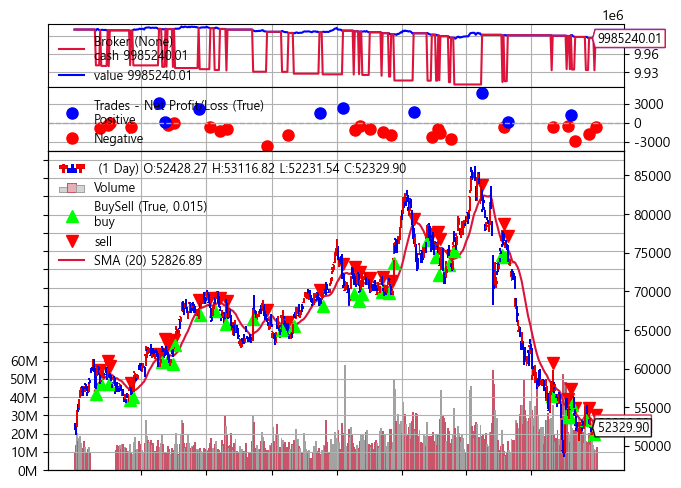

[[<Figure size 640x480 with 4 Axes>]]

In [86]:
# iplot = False : 2가지 backend 선택 가능
# backend 를 inline 으로 실행
%matplotlib inline
cerebro_analyzer.plot(style='candlestick', barup='red', bardown='blue', iplot=False)

In [84]:
print("interactive:", plt.isinteractive())
print("backend:", plt.get_backend())

interactive: False
backend: TkAgg


### 8.2 커스텀 그래프

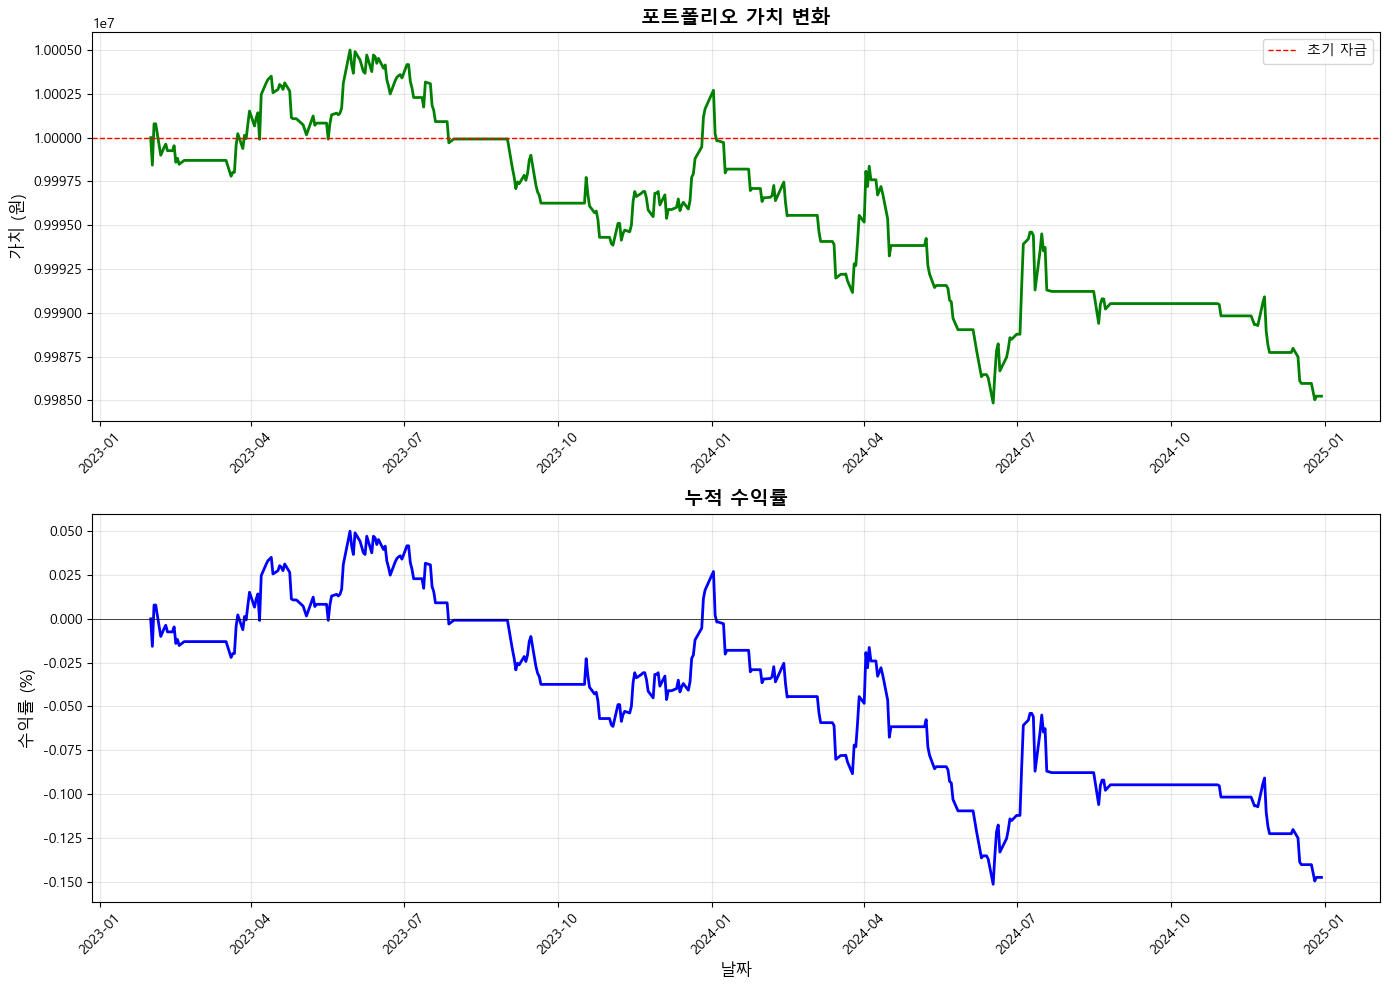

In [87]:
# 포트폴리오 가치 추출
portfolio_values = []
dates = []

class ValueTracker(bt.Strategy):
    """포트폴리오 가치 추적"""
    
    def __init__(self):
        self.sma = bt.indicators.SMA(self.data.close, period=20)
        self.order = None
    
    def next(self):
        # 매일 포트폴리오 가치 저장
        portfolio_values.append(self.broker.getvalue())
        dates.append(self.data.datetime.date(0))
        
        if self.order:
            return
        
        if self.data.close[0] > self.sma[0] and not self.position:
            self.order = self.buy()
        elif self.data.close[0] < self.sma[0] and self.position:
            self.order = self.close()
    
    def notify_order(self, order):
        if order.status in [order.Completed]:
            self.order = None

# 실행
cerebro_custom = bt.Cerebro()
cerebro_custom.broker.setcash(10_000_000)
cerebro_custom.broker.setcommission(commission=0.001)
cerebro_custom.adddata(data_bt)
cerebro_custom.addstrategy(ValueTracker)
cerebro_custom.run()

# 그래프 그리기
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 포트폴리오 가치
axes[0].plot(dates, portfolio_values, linewidth=2, color='green')
axes[0].axhline(y=10_000_000, color='red', linestyle='--', linewidth=1, label='초기 자금')
axes[0].set_title('포트폴리오 가치 변화', fontsize=14, fontweight='bold')
axes[0].set_ylabel('가치 (원)', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# 누적 수익률
initial_value = portfolio_values[0]
returns = [(v / initial_value - 1) * 100 for v in portfolio_values]
axes[1].plot(dates, returns, linewidth=2, color='blue')
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
axes[1].set_title('누적 수익률', fontsize=14, fontweight='bold')
axes[1].set_ylabel('수익률 (%)', fontsize=12)
axes[1].set_xlabel('날짜', fontsize=12)
axes[1].grid(alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---
## Part 9: 실전 팁과 주의사항

### 9.1 데이터 접근하기

```python
# 현재 데이터
self.data.close[0]      # 현재 종가
self.data.open[0]       # 현재 시가
self.data.high[0]       # 현재 고가
self.data.low[0]        # 현재 저가
self.data.volume[0]     # 현재 거래량

# 과거 데이터
self.data.close[-1]     # 어제 종가
self.data.close[-5]     # 5일 전 종가

# 미래 데이터는 접근 불가!
# self.data.close[1]    # 에러!
```

### 9.2 자주 하는 실수

In [24]:
class CommonMistakes(bt.Strategy):
    """
    자주 하는 실수 예제
    """
    
    def __init__(self):
        self.sma = bt.indicators.SMA(self.data.close, period=20)
    
    def next(self):
        # 실수 1: 주문 중복 체크 안함
        # if self.data.close[0] > self.sma[0]:
        #     self.buy()  # 매일 주문이 나감!
        
        # 올바른 방법
        if self.data.close[0] > self.sma[0] and not self.position:
            self.buy()
        
        # 실수 2: 지표가 준비되기 전에 사용
        # if len(self) < 20:  # SMA(20) 계산 안됨
        #     if self.sma[0] > 100:  # 에러 또는 이상한 값!
        
        # 올바른 방법
        if len(self) >= 20:  # 충분한 데이터 확보 후
            if self.sma[0] > 100:
                pass
        
        # 실수 3: 미래 데이터 사용 (Look-ahead bias)
        # future_price = self.data.close[1]  # 미래를 볼 수 없음!
        
        # 올바른 방법
        current_price = self.data.close[0]  # 현재 또는 과거만

### 9.3 성능 최적화 팁

In [25]:
class OptimizationTips(bt.Strategy):
    """
    성능 최적화 팁
    """
    
    def __init__(self):
        # 팁 1: 지표는 __init__에서 미리 계산
        self.sma = bt.indicators.SMA(self.data.close, period=20)
        
        # 팁 2: 복잡한 계산은 한 번만
        self.crossover = bt.indicators.CrossOver(
            bt.indicators.SMA(self.data.close, period=10),
            bt.indicators.SMA(self.data.close, period=30)
        )
    
    def next(self):
        # 비효율: next()에서 매번 계산
        # sma20 = sum(self.data.close.get(size=20)) / 20
        
        # 효율적: 미리 계산한 지표 사용
        if self.crossover > 0:
            self.buy()

### 9.4 디버깅 팁

In [26]:
class DebuggingTips(bt.Strategy):
    """
    디버깅 유용한 정보들
    """
    
    def __init__(self):
        self.sma = bt.indicators.SMA(self.data.close, period=20)
    
    def next(self):
        # 현재 날짜
        current_date = self.data.datetime.date(0)
        
        # 현재 막대(bar) 번호 (0부터 시작)
        bar_number = len(self)
        
        # 브로커 정보
        cash = self.broker.getcash()          # 현금
        value = self.broker.getvalue()        # 총 자산
        
        # 포지션 정보
        pos_size = self.position.size         # 보유 수량
        pos_price = self.position.price       # 평균 매입가
        
        # 디버깅 출력 (처음 3일만)
        if bar_number <= 3:
            print(f"\n날짜: {current_date} (Bar #{bar_number})")
            print(f"   종가: {self.data.close[0]:,.0f}원")
            print(f"   SMA: {self.sma[0]:,.0f}원")
            print(f"   현금: {cash:,.0f}원")
            print(f"   총자산: {value:,.0f}원")
            print(f"   포지션: {pos_size}주 @ {pos_price:,.0f}원")

---
## 정리

### 배운 내용

1. **기본 구조**: Cerebro, Data, Strategy, Broker
2. **Strategy 작성**: `__init__()`, `next()`, `notify_order()`
3. **주문 관리**: `buy()`, `sell()`, `close()`
4. **지표 사용**: SMA, RSI, MACD, 볼린저밴드 등
5. **포지션 관리**: `self.position` 활용
6. **브로커 설정**: 초기자금, 수수료, 슬리피지
7. **분석기**: Returns, Sharpe, DrawDown, TradeAnalyzer
8. **시각화**: `plot()`, 커스텀 그래프
9. **실전 팁**: 흔한 실수, 최적화, 디버깅

### 참고 자료

- 공식 문서: https://www.backtrader.com/docu/
- 예제 코드: https://github.com/mementum/backtrader
- 커뮤니티: https://community.backtrader.com/

# 전략 예시

In [27]:
import backtrader as bt

class IndicatorDemo(bt.Strategy):
    """
    SMA20 / SMA60 + MACD 골든크로스 진입
    ATR 기반 손절/익절 + 포지션 사이즈 조절 전략
    """

    params = dict(
        fast_ma=20,
        slow_ma=60,
        macd_me1=12,
        macd_me2=26,
        macd_signal=9,
        atr_period=14,
        atr_stop_mult=2.0,    # 손절: 2 * ATR
        atr_target_mult=3.0,  # 익절: 3 * ATR
        risk_perc=0.01,       # 계좌당 1% 리스크
    )

    def __init__(self):
        # ===== 1. 지표 정의 =====
        self.sma_fast = bt.indicators.SMA(self.data.close, period=self.p.fast_ma)
        self.sma_slow = bt.indicators.SMA(self.data.close, period=self.p.slow_ma)

        self.rsi = bt.indicators.RSI(self.data.close, period=14)  # 데모용, 전략에는 직접 사용 안 함

        self.macd = bt.indicators.MACD(
            self.data.close,
            period_me1=self.p.macd_me1,
            period_me2=self.p.macd_me2,
            period_signal=self.p.macd_signal
        )

        self.bbands = bt.indicators.BollingerBands(self.data.close, period=20)

        self.atr = bt.indicators.ATR(self.data, period=self.p.atr_period)

        # ===== 2. 주문/포지션 관리용 변수 =====
        self.order = None           # 현재 진행 중인 주문
        self.entry_price = None     # 진입가
        self.atr_at_entry = None    # 진입 시 ATR
        self.stop_price = None      # 손절가
        self.take_profit = None     # 익절가

        print("지표 + 전략 초기화 완료")
        print("  - SMA({}, {})".format(self.p.fast_ma, self.p.slow_ma))
        print("  - MACD({}, {}, {})".format(
            self.p.macd_me1, self.p.macd_me2, self.p.macd_signal
        ))
        print("  - ATR({})".format(self.p.atr_period))

    # ===== 주문 상태 알림 =====
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # 제출/체결 대기 상태는 굳이 로그 안 찍어도 됨
            return

        if order.status == order.Completed:
            if order.isbuy():
                print(f"\n[BUY 체결] {self.data.datetime.date(0)}")
                print(f"  가격: {order.executed.price:,.2f}")
                print(f"  수량: {order.executed.size}")
                print(f"  수수료: {order.executed.comm:,.0f}")
            else:
                print(f"\n[SELL 체결] {self.data.datetime.date(0)}")
                print(f"  가격: {order.executed.price:,.2f}")
                print(f"  수량: {order.executed.size}")
                print(f"  수수료: {order.executed.comm:,.0f}")

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print(f"\n[주문 실패] {order.Status[order.status]}")

        # 한 번 처리된 주문은 초기화
        self.order = None

    # ===== 트레이드 종료 알림 =====
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        print(f"\n[트레이드 종료] {self.data.datetime.date(0)}")
        print(f"  총 PnL: {trade.pnl:,.0f}원")
        print(f"  순 PnL: {trade.pnlcomm:,.0f}원 (수수료 포함)")

    # ===== 핵심 로직 =====
    def next(self):
        # 진행 중인 주문이 있으면 새로운 의사결정은 하지 않음
        if self.order:
            return

        # 지표가 안정적으로 계산될 때까지 (슬로우 MA / MACD / ATR 기간) 대기
        min_bars = max(self.p.slow_ma, self.p.macd_me2, self.p.atr_period)
        if len(self.data) < min_bars:
            return

        # 추세 필터: SMA20 > SMA60 (상승 추세에서만 매수)
        uptrend = self.sma_fast[0] > self.sma_slow[0]

        # MACD 골든크로스: 직전 bar에서 아래, 현재 bar에서 위
        macd_now = self.macd.macd[0]
        macd_prev = self.macd.macd[-1]
        signal_now = self.macd.signal[0]
        signal_prev = self.macd.signal[-1]

        macd_golden_cross = (macd_prev < signal_prev) and (macd_now > signal_now)

        # ===== 1) 포지션 없을 때: 진입 =====
        if not self.position:
            if uptrend and macd_golden_cross:
                atr_now = float(self.atr[0])
                if atr_now <= 0:
                    return  # ATR 이상치 방어

                # 계좌 가치 기준 리스크 한도
                account_value = self.broker.getvalue()
                risk_amount = account_value * self.p.risk_perc

                # 손절폭 = atr_stop_mult * ATR
                stop_distance = self.p.atr_stop_mult * atr_now

                # 수량 = (허용 리스크) / (손절폭)
                size = risk_amount / stop_distance
                size = int(size)  # 정수 주식 수

                if size <= 0:
                    return

                # 진입가/손절/익절 계산
                self.entry_price = float(self.data.close[0])
                self.atr_at_entry = atr_now
                self.stop_price = self.entry_price - self.p.atr_stop_mult * self.atr_at_entry
                self.take_profit = self.entry_price + self.p.atr_target_mult * self.atr_at_entry

                print(f"\n[진입 시그널] {self.data.datetime.date(0)}")
                print(f"  계좌 가치: {account_value:,.0f}원")
                print(f"  ATR(현재): {atr_now:,.2f}")
                print(f"  매수 수량: {size:,}주")
                print(f"  진입가(현재 종가): {self.entry_price:,.2f}")
                print(f"  손절가(2*ATR): {self.stop_price:,.2f}")
                print(f"  익절가(3*ATR): {self.take_profit:,.2f}")

                # 시장가 매수 주문
                self.order = self.buy(size=size)

        # ===== 2) 포지션 있을 때: 손절/익절 관리 =====
        else:
            current_price = float(self.data.close[0])

            # 손절 조건: 현재가가 손절가 이하
            if current_price <= self.stop_price:
                print(f"\n[손절 발동] {self.data.datetime.date(0)}")
                print(f"  현재가: {current_price:,.2f} <= 손절가: {self.stop_price:,.2f}")
                self.order = self.close()  # 전체 청산

            # 익절 조건: 현재가가 익절가 이상
            elif current_price >= self.take_profit:
                print(f"\n[익절 발동] {self.data.datetime.date(0)}")
                print(f"  현재가: {current_price:,.2f} >= 익절가: {self.take_profit:,.2f}")
                self.order = self.close()

            # (옵션) 추세 붕괴 시 청산: SMA20 < SMA60 되면 포지션 정리하는 조건도 추가 가능
            # elif self.sma_fast[0] < self.sma_slow[0]:
            #     print(f"\n[추세 붕괴로 청산] {self.data.datetime.date(0)}")
            #     self.order = self.close()


# ===== 실행 예시 =====
# 이미 data_bt (PandasData 등) 가 준비되어 있다고 가정
cerebro_sample = bt.Cerebro()
cerebro_sample.broker.setcash(10_000_000)  # 초기 1,000만원
cerebro_sample.adddata(data_bt)
cerebro_sample.addstrategy(IndicatorDemo)

print(f"\n{'='*60}")
print("지표 + MACD/ATR 전략 데모 실행")
print(f"{'='*60}")

results = cerebro_sample.run()
final_value = cerebro_sample.broker.getvalue()
print(f"\n최종 계좌 가치: {final_value:,.0f}원")



지표 + MACD/ATR 전략 데모 실행
지표 + 전략 초기화 완료
  - SMA(20, 60)
  - MACD(12, 26, 9)
  - ATR(14)

[진입 시그널] 2023-05-19
  계좌 가치: 10,000,000원
  ATR(현재): 1,115.04
  매수 수량: 44주
  진입가(현재 종가): 64,883.29
  손절가(2*ATR): 62,653.21
  익절가(3*ATR): 68,228.39

[BUY 체결] 2023-05-22
  가격: 64,883.30
  수량: 44
  수수료: 0

[익절 발동] 2023-05-30
  현재가: 68,582.77 >= 익절가: 68,228.39

[SELL 체결] 2023-05-31
  가격: 68,677.63
  수량: -44
  수수료: 0

[트레이드 종료] 2023-05-31
  총 PnL: 166,950원
  순 PnL: 166,950원 (수수료 포함)

[진입 시그널] 2023-11-28
  계좌 가치: 10,166,950원
  ATR(현재): 1,063.36
  매수 수량: 47주
  진입가(현재 종가): 69,668.76
  손절가(2*ATR): 67,542.03
  익절가(3*ATR): 72,858.85

[BUY 체결] 2023-11-29
  가격: 69,381.27
  수량: 47
  수수료: 0

[익절 발동] 2023-12-26
  현재가: 73,406.16 >= 익절가: 72,858.85

[SELL 체결] 2023-12-27
  가격: 73,850.02
  수량: -47
  수수료: 0

[트레이드 종료] 2023-12-27
  총 PnL: 210,032원
  순 PnL: 210,032원 (수수료 포함)

[진입 시그널] 2024-02-05
  계좌 가치: 10,376,982원
  ATR(현재): 1,466.82
  매수 수량: 35주
  진입가(현재 종가): 71,539.21
  손절가(2*ATR): 68,605.57
  익절가(3*ATR): 75,939.68

[BU

MACD + ATR 전략 백테스트 실행

[진입] 2023-05-19 가격: 64,883.29, 수량: 44, 손절: 62,653.21, 익절: 68,228.39
[익절] 2023-05-30 현재가 68,582.77 >= 익절가 68,228.39
[트레이드 종료] 2023-05-31 총 PnL: 166,950, 순 PnL: 161,074

[진입] 2023-11-28 가격: 69,668.76, 수량: 47, 손절: 67,542.03, 익절: 72,858.85
[익절] 2023-12-26 현재가 73,406.16 >= 익절가 72,858.85
[트레이드 종료] 2023-12-27 총 PnL: 210,032, 순 PnL: 203,300

[진입] 2024-02-05 가격: 71,539.21, 수량: 35, 손절: 68,605.57, 익절: 75,939.68
[익절] 2024-03-21 현재가 76,353.41 >= 익절가 75,939.68
[트레이드 종료] 2024-03-22 총 PnL: 178,607, 순 PnL: 173,421

[진입] 2024-05-08 가격: 78,634.83, 수량: 28, 손절: 74,905.61, 익절: 84,228.65
[손절] 2024-05-17 현재가 74,862.69 <= 손절가 74,905.61
[트레이드 종료] 2024-05-20 총 PnL: -81,247, 순 PnL: -85,558

최종 계좌 가치: 10,452,236원


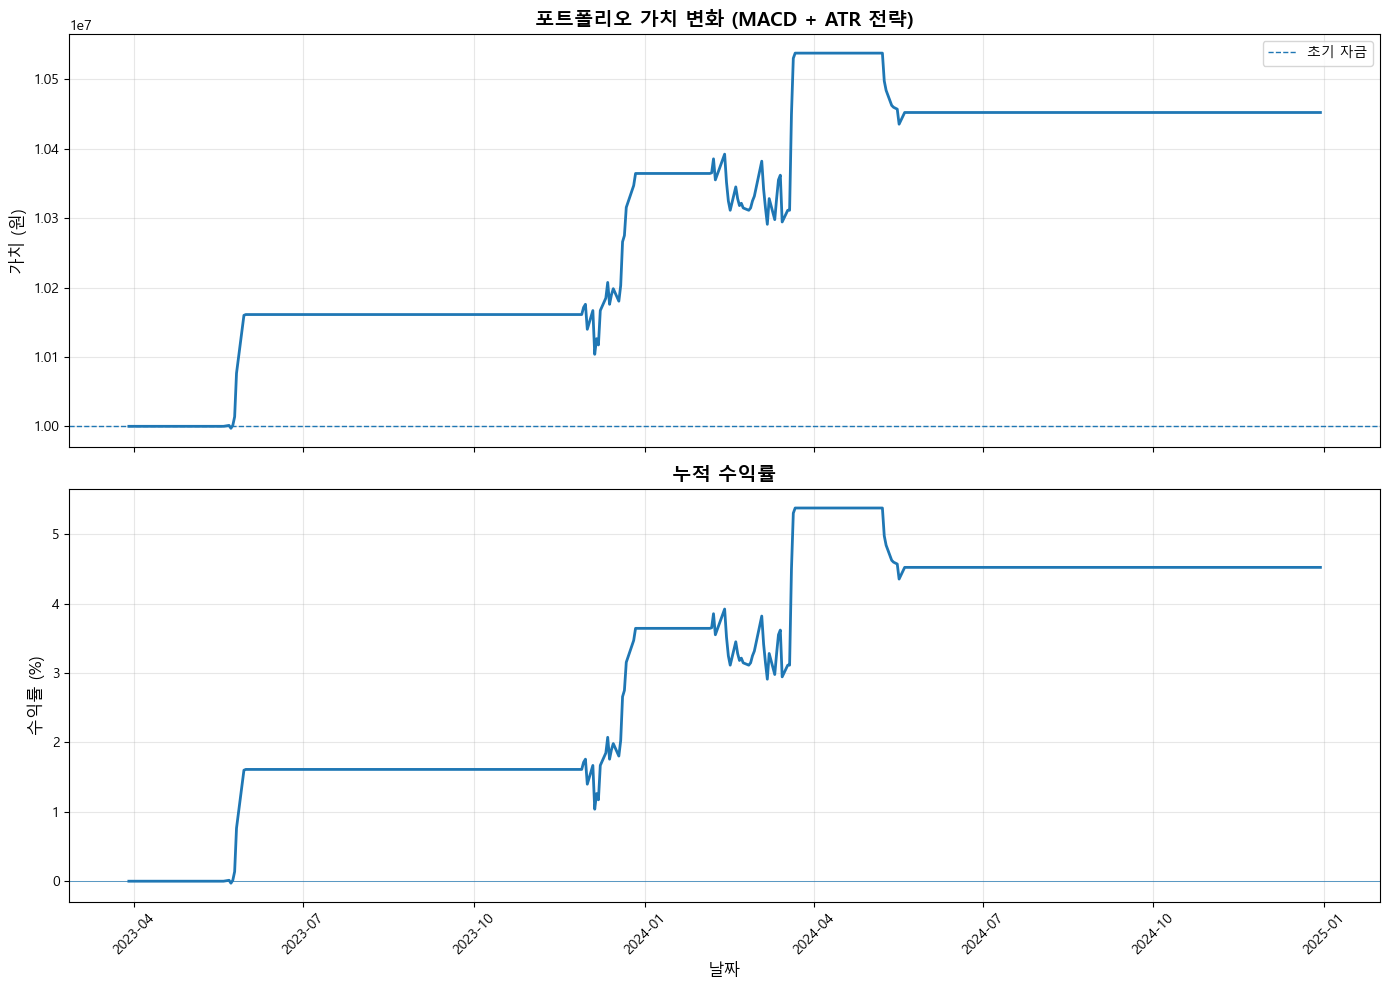

In [88]:
import backtrader as bt
import matplotlib.pyplot as plt


class MacdAtrStrategy(bt.Strategy):
    """
    SMA20 / SMA60 + MACD 골든크로스 진입
    ATR 기반 손절/익절 + 포지션 사이즈 조절 전략
    + 포트폴리오 가치/누적 수익률 추적
    """

    params = dict(
        fast_ma=20,
        slow_ma=60,
        macd_me1=12,
        macd_me2=26,
        macd_signal=9,
        atr_period=14,
        atr_stop_mult=2.0,    # 손절: 2 * ATR
        atr_target_mult=3.0,  # 익절: 3 * ATR
        risk_perc=0.01,       # 계좌당 1% 리스크
    )

    def __init__(self):
        # ===== 지표 =====
        self.sma_fast = bt.indicators.SMA(self.data.close, period=self.p.fast_ma)
        self.sma_slow = bt.indicators.SMA(self.data.close, period=self.p.slow_ma)

        self.macd = bt.indicators.MACD(
            self.data.close,
            period_me1=self.p.macd_me1,
            period_me2=self.p.macd_me2,
            period_signal=self.p.macd_signal
        )

        self.atr = bt.indicators.ATR(self.data, period=self.p.atr_period)

        # ===== 2. 주문/포지션 관리용 변수 =====
        self.order = None           # 현재 진행 중인 주문
        self.entry_price = None     # 진입가
        self.atr_at_entry = None    # 진입 시 ATR
        self.stop_price = None      # 손절가
        self.take_profit = None     # 익절가

        # 포트폴리오 가치 추적용
        self.values = []
        self.dates = []

    # ===== 주문 상태 알림 =====
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status == order.Completed:
            # 체결 완료 후 주문 플래그만 해제
            self.order = None

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            print(f"[주문 실패] {order.Status[order.status]}")
            self.order = None

    # ===== 트레이드 종료 알림 =====
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        print(f"[트레이드 종료] {self.data.datetime.date(0)} "
              f"총 PnL: {trade.pnl:,.0f}, 순 PnL: {trade.pnlcomm:,.0f}")

    def next(self):
        # === 1) 매 Bar마다 포트폴리오 가치/날짜 기록 ===
        self.values.append(self.broker.getvalue())
        self.dates.append(self.data.datetime.date(0))

        # 진행 중인 주문이 있으면 신규 의사결정 하지 않음
        if self.order:
            return

        # 지표가 충분히 계산된 이후부터 동작
        # (슬로우 MA / MACD / ATR 기간) 대기
        min_bars = max(self.p.slow_ma, self.p.macd_me2, self.p.atr_period)
        if len(self.data) < min_bars:
            return

        # 추세 필터: SMA20 > SMA60 (상승 추세에서만 매수)
        uptrend = self.sma_fast[0] > self.sma_slow[0]

        # MACD 골든크로스: 직전 bar에서 아래, 현재 bar에서 위
        macd_now = self.macd.macd[0]
        macd_prev = self.macd.macd[-1]
        sig_now = self.macd.signal[0]
        sig_prev = self.macd.signal[-1]

        macd_golden = (macd_prev < sig_prev) and (macd_now > sig_now)

        # === 2) 포지션 없을 때: 진입 ===
        if not self.position:
            if uptrend and macd_golden:
                atr_now = float(self.atr[0])
                if atr_now <= 0:
                    return  # ATR 이상치 방어

                # 계좌 가치 기준 리스크 한도
                account_value = self.broker.getvalue()
                risk_amount = account_value * self.p.risk_perc
                # 손절폭 = atr_stop_mult * ATR
                stop_distance = self.p.atr_stop_mult * atr_now

                # 수량 = (허용 리스크) / (손절폭)
                size = risk_amount / stop_distance
                size = int(size)    # 정수 주식 수
                if size <= 0:
                    return

                # 진입가/손절/익절 계산
                self.entry_price = float(self.data.close[0])
                self.atr_at_entry = atr_now
                self.stop_price = self.entry_price - self.p.atr_stop_mult * self.atr_at_entry
                self.take_profit = self.entry_price + self.p.atr_target_mult * self.atr_at_entry

                print(f"\n[진입] {self.data.datetime.date(0)} "
                      f"가격: {self.entry_price:,.2f}, 수량: {size}, "
                      f"손절: {self.stop_price:,.2f}, 익절: {self.take_profit:,.2f}")

                self.order = self.buy(size=size)

        # === 3) 포지션 있을 때: 손절/익절 관리 ===
        else:
            current_price = float(self.data.close[0])

            # 손절 조건: 현재가가 손절가 이하
            if current_price <= self.stop_price:
                print(f"[손절] {self.data.datetime.date(0)} "
                      f"현재가 {current_price:,.2f} <= 손절가 {self.stop_price:,.2f}")
                self.order = self.close()

            # 익절 조건: 현재가가 익절가 이상
            elif current_price >= self.take_profit:
                print(f"[익절] {self.data.datetime.date(0)} "
                      f"현재가 {current_price:,.2f} >= 익절가 {self.take_profit:,.2f}")
                self.order = self.close()


# ==============================
# 2. 실행 파트 (data_bt 가 있다고 가정)
# ==============================
cerebro = bt.Cerebro()
cerebro.broker.setcash(10_000_000)
cerebro.broker.setcommission(commission=0.001)

cerebro.adddata(data_bt)              # 이미 만든 DataFeed
cerebro.addstrategy(MacdAtrStrategy)  # ★ 여기서 ValueTracker 대신 이 전략 사용

print("=" * 60)
print("MACD + ATR 전략 백테스트 실행")
print("=" * 60)

results = cerebro.run()
strat = results[0]

final_value = cerebro.broker.getvalue()
print(f"\n최종 계좌 가치: {final_value:,.0f}원")


# ==============================
# 3. 포트폴리오 가치 / 누적 수익률 그래프
# ==============================
portfolio_values = strat.values
dates = strat.dates

fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# (1) 포트폴리오 가치
axes[0].plot(dates, portfolio_values, linewidth=2)
axes[0].axhline(
    y=portfolio_values[0],
    linestyle='--',
    linewidth=1,
    label='초기 자금'
)
axes[0].set_title('포트폴리오 가치 변화 (MACD + ATR 전략)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('가치 (원)', fontsize=12)
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].tick_params(axis='x', rotation=45)

# (2) 누적 수익률
initial_value = portfolio_values[0]
returns = [(v / initial_value - 1) * 100 for v in portfolio_values]

axes[1].plot(dates, returns, linewidth=2)
axes[1].axhline(y=0, linestyle='-', linewidth=0.5)
axes[1].set_title('누적 수익률', fontsize=14, fontweight='bold')
axes[1].set_ylabel('수익률 (%)', fontsize=12)
axes[1].set_xlabel('날짜', fontsize=12)
axes[1].grid(alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
